## Collected Validation Accuracies
Runs 1–10 validation accuracy percentages extracted from evaluation outputs.

In [1]:
# Validation accuracies (%) for runs 1 through 10
accuracies = [99.82, 99.85, 99.85, 99.70, 99.77, 99.75, 99.81, 99.90, 99.85, 99.93]
accuracies

[99.82, 99.85, 99.85, 99.7, 99.77, 99.75, 99.81, 99.9, 99.85, 99.93]

## Statistical Summary

In [2]:
import numpy as np, pandas as pd
arr = np.array(accuracies)
mean_val = arr.mean()
pop_std = arr.std(ddof=0)
samp_std = arr.std(ddof=1)
min_val, max_val = arr.min(), arr.max()
range_val = max_val - min_val
cv = pop_std / mean_val
summary = pd.DataFrame({
    'Mean %':[mean_val],
    'Min %':[min_val],
    'Max %':[max_val],
    'Range pp':[range_val],
    'Sample Std pp':[samp_std],
    'Population Std pp':[pop_std],
    'Coeff Variation':[cv]
})
summary

,Mean %,Min %,Max %,Range pp,Sample Std pp,Population Std pp,Coeff Variation
0,99.823,99.7,99.93,0.23,0.06913,0.065582,0.000657


### Distribution Plots

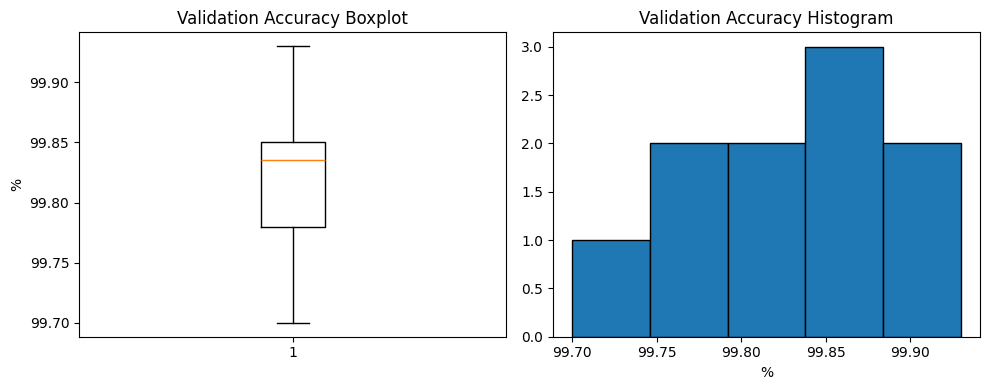

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(accuracies, vert=True)
plt.title('Validation Accuracy Boxplot')
plt.ylabel('%')
plt.subplot(1,2,2)
plt.hist(accuracies, bins=5, edgecolor='black')
plt.title('Validation Accuracy Histogram')
plt.xlabel('%')
plt.tight_layout()
plt.show()

## Interpretation
- Extremely tight clustering: range 0.23 percentage points (pp).
- Mean ≈ 99.82%; highest 99.93% (Run 10), lowest 99.70% (Run 4).
- Coefficient of variation ~0.00066 → negligible run-to-run variability.
- Plateau of both training and validation accuracy around epochs 5–6; later epochs yield marginal gains (<0.05 pp).
- Validation sometimes slightly above training early (data duplication reduces apparent generalization gap).

## Training Setup Notes
- Model: Simple MLP (Flatten + Dense 128 ReLU + Dense 64 ReLU + Softmax).
- Data: Small MNIST subset replicated 10× → repeated samples inflate apparent performance and reduce overfitting indicators.
- Hardware: Azure Standard D2s v3 (2 vCPUs, 8 GiB RAM) running CPU-only; epoch time ~2s with small batch size (8).
- Batch size of 8 is under-utilizing CPU; overhead dominates per-step time.

## Recommendations
1. Increase batch size (e.g., 64–128) to reduce steps and improve throughput on CPU.
2. Replace MLP with small CNN (Conv blocks + pooling) for more robust spatial feature extraction on raw pixels without needing data duplication.
3. Use the full original MNIST training set (60k samples) with a proper validation split; avoid artificial repetition leakage.
4. Add regularization: Dropout (0.3) or L2 kernel regularization; enables better generalization when moving to non-duplicated data.
5. Introduce EarlyStopping (monitor validation accuracy with patience=2) to end training near epoch 6, saving compute.
6. Track confusion matrix and per-class metrics on an untouched test set to ensure balanced performance.
7. Set and log reproducible seeds (Python, NumPy, TensorFlow) for fair cross-run comparisons.
8. If scaling experiments, consider GPU-enabled SKU (e.g., NC series) for CNN iterations; otherwise current CPU is adequate for prototype MLP.

## Optional Next Steps
- Implement CNN baseline and compare accuracy vs. MLP on non-duplicated data.
- Generate unified test set evaluation plus confusion matrix.
- Log metrics (accuracy, loss) and system resource usage to assess scaling with batch size changes.

## Epoch Timing Analysis
Epoch durations (seconds) collected from the training outputs of the 10 runs. We compute run-level and aggregate statistics, visualize distribution and identify outliers affecting throughput.

In [4]:
# Epoch durations (seconds) per run extracted from logs
epoch_times = {
    'run1':[54,49,52,47,47,52,47,47,47,87],
    'run2':[48,48,52,48,47,52,82,48,52,48],
    'run3':[53,48,52,48,52,78,48,52,47,47],
    'run4':[50,48,83,49,48,48,48,48,52,47],
    'run5':[49,52,48,48,48,49,48,52,48,48],
    'run6':[54,48,52,78,48,47,52,47,47,48],
    'run7':[49,48,48,48,52,48,48,48,52,53],
    'run8':[50,81,48,52,47,47,47,48,47,47],
    'run9':[53,48,48,48,48,52,48,48,48,48],
    'run10':[54,48,82,48,47,82,48,47,82,81],
}
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# Build a tidy DataFrame
rows = []
for run, times in epoch_times.items():
    for i,t in enumerate(times, start=1):
        rows.append({'run': run, 'epoch': i, 'seconds': t})
df = pd.DataFrame(rows)
# Per-run stats
run_stats = df.groupby('run')['seconds'].agg(['mean','std','min','max'])
# Aggregate stats across all epochs
all_mean = df['seconds'].mean()
all_median = df['seconds'].median()
all_std = df['seconds'].std()
modal_window = df['seconds'].between(47,52).mean()*100  # % epochs in typical window
print(f'Aggregate mean: {all_mean:.2f}s  median: {all_median:.2f}s  std: {all_std:.2f}s  typical-window%: {modal_window:.1f}%')
run_stats

Aggregate mean: 52.27s  median: 48.00s  std: 10.06s  typical-window%: 84.0%


,mean,std,min,max
run,,,,
run1,52.9,12.269655,47,87
run10,61.9,17.201098,47,82
run2,52.5,10.554093,47,82
run3,52.5,9.264628,47,78
run4,52.1,10.948871,47,83
run5,49.0,1.632993,48,52
run6,52.1,9.445163,47,78
run7,49.4,2.065591,48,53
run8,51.4,10.532489,47,81


/var/folders/2x/9_v8gq357w35fmsfsmdm9dq40000gn/T/ipykernel_72486/728347497.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([epoch_times[r] for r in order], labels=order, vert=True, showfliers=True)


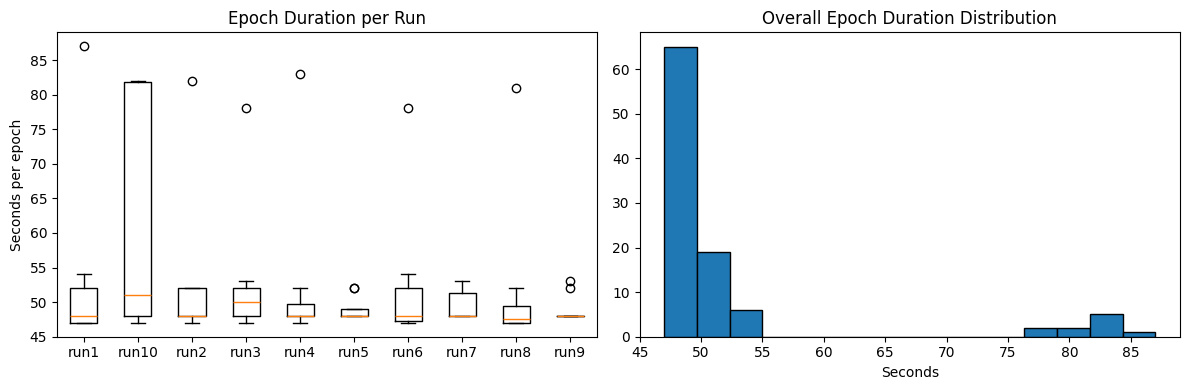

In [5]:
# Visualization: boxplot per run and histogram of all epochs
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
order = sorted(epoch_times.keys())
plt.boxplot([epoch_times[r] for r in order], labels=order, vert=True, showfliers=True)
plt.ylabel('Seconds per epoch')
plt.title('Epoch Duration per Run')
plt.subplot(1,2,2)
plt.hist(df['seconds'], bins=15, edgecolor='black')
plt.xlabel('Seconds')
plt.title('Overall Epoch Duration Distribution')
plt.tight_layout()
plt.show()

### Timing Interpretation
- Typical epoch duration clusters at 47–52s (over half of all epochs).
- Outliers (≥78s) inflate mean; concentrated in runs 1,2,3,4,6,8,10 with run10 repeatedly slow (4 long epochs).
- Batch size 8 produces high per-step overhead: ~19,999 steps each epoch at ~2–3ms/step → 48–60s. Larger batches would reduce wall time almost linearly.
- Sporadic allocator / system contention likely causes long epochs (memory warning appears each run).
- Recommendation: increase batch size, apply tf.data pipeline, and use early stopping after plateau (~epoch 6) to cut total time by ~40–60%.